# IMA205 Challenge

Louis Martinez

For the whole notebook we will denote the research papers as follows :

- [[1]](https://link.springer.com/book/10.1007/978-3-319-75541-0) : Statistical Atlases and Computational Models of the Heart. ACDC and MMWHS Challenges
- [[2]](https://www.sciencedirect.com/science/article/pii/S0010482505000430) : Automatic segmentation of the left ventricle cavity and myocardium in MRI data

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

## Loading data

We define some constants related to the challenge

In [2]:
BG_IDX=0
RV_IDX=1
MYO_IDX=2
LV_IDX=3

MASK_IDX = {
    'ed': 1, 'es': 3 
}

MRI_IDX = {
    'ed': 0, 'es': 2
}

SUBMISSION_FILE = './SampleSubmission.csv'

Then we define some utility functions

In [3]:
def load_mris(dir):
    """Function to load all mris from test and train directories"""
    mris = []
    for sample in os.listdir(dir):
        mri_dir = os.path.join(dir, sample)
        sample_mris = []
        for mri in os.listdir(mri_dir):
            # Load mri
            mri_data = nib.load(os.path.join(mri_dir, mri)).get_fdata().transpose(2,0,1)
            sample_mris.append(mri_data)

        mris.append(sample_mris)

    return np.array(mris, dtype=object)


def plot_slices(slices, title=None):
    """Function to plot slices of a MRI"""
    n_slices=slices.shape[0]
    n_rows, n_cols=0, 0
    if n_slices%5==0:
        n_rows=n_slices//5
    else:
        n_rows=n_slices//5+1

    if n_slices<5:
        n_cols=n_slices
    else:
        n_cols=5

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    ax=axes.ravel()
    for i, slice in enumerate(slices):
        ax[i].pcolormesh(slice)
        ax[i].set_title(f'Slice {i}')
    if title:
        fig.suptitle(title, fontsize=20)
    plt.show()

def save_to_csv(y,csv_in=SUBMISSION_FILE, csv_out=SUBMISSION_FILE, col_name='Category'):
    submit_csv=pd.read_csv(csv_in)
    submit_csv[col_name]=y
    submit_csv.to_csv(csv_out, index=False)
    print(f'Results successfully saved to {csv_out}')

def normalize(img):
    return ((img - img.min())/ (img.max() - img.min()))*255

In [4]:
# LOAD CSV FILES

train_csv='metaDataTrain.csv'
test_csv='metaDataTest.csv'

df_train=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)

X_train_df=df_train[['Height','Weight']]
X_test_df=df_test[['Height','Weight']]

X_train=X_train_df.to_numpy()
y_train=df_train[['Category']].to_numpy().ravel()
X_test=X_test_df.to_numpy()

X_cat = [X_train[y_train == i] for i in range(y_train.max() + 1)] # split by category

In [5]:
# LOAD MRIs

train_dir = 'Train'
test_dir = 'Test'

mri_train = load_mris(train_dir)
mri_test = load_mris(test_dir)

# Format MRI and segmentation masks as (num_slices, height, width)
n_train_samples, n_train_mri = mri_train.shape
n_test_samples, n_test_mri = mri_test.shape

print(f'Train MRI shape: {mri_train.shape}')
print(f'Test MRI shape: {mri_test.shape}')
print(f'Shape of first MRI : {mri_train[0][0].shape}')

Train MRI shape: (100, 4)
Test MRI shape: (50, 4)
Shape of first MRI : (10, 216, 256)


For ease of use, we change the format the MRIs as (num_slices, height, width). This way we just need to write `plt.pcolor(mri[i])` instead of `plt.pcolor(mri[:,:,i])`

In [6]:



# for i in range(n_train_samples):
#     for j in range(n_train_mri):
#         mri_train[i][j] = np.transpose(mri_train[i][j], (2, 0, 1))

# for i in range(n_test_samples):
#     for j in range(n_test_mri):
#         mri_test[i][j] = np.transpose(mri_test[i][j], (2, 0, 1))

# print(f'Train MRI shape: {mri_train.shape}')
# print(f'Test MRI shape: {mri_test.shape}')
# print(f'MRI shape : {mri_train[0][0].shape}')

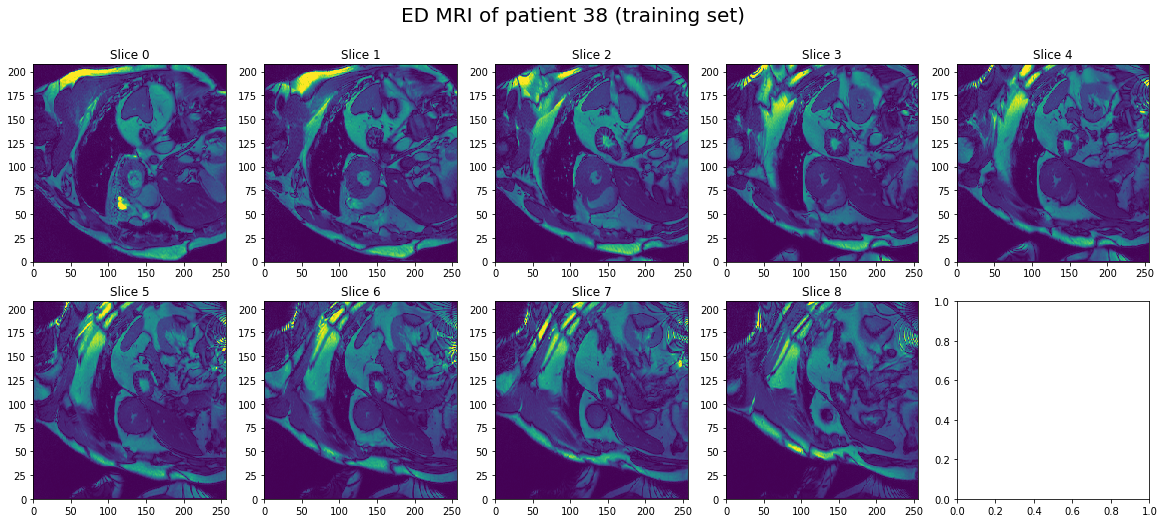

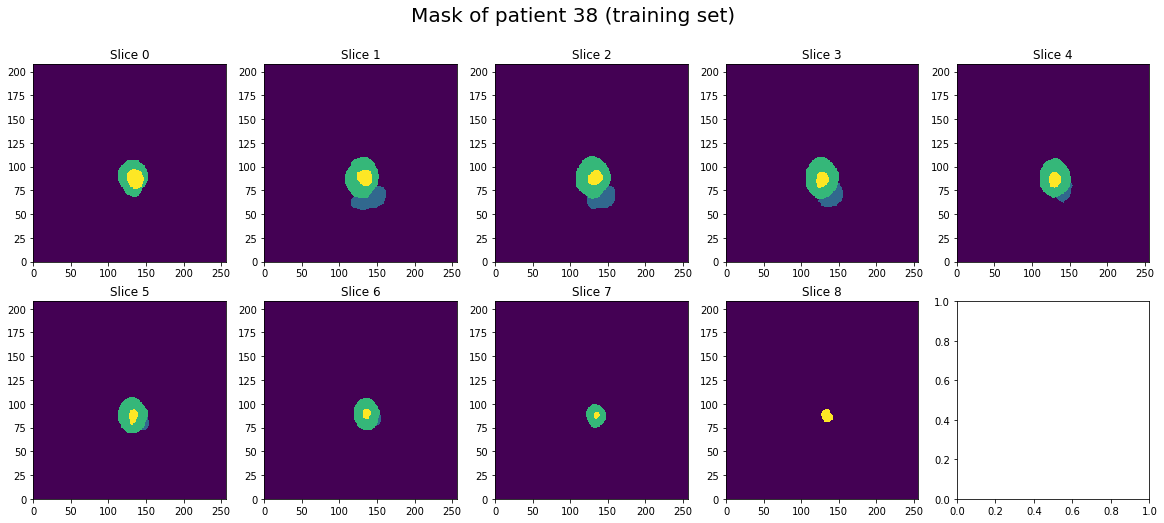

In [7]:
patient_idx=np.random.randint(mri_train.shape[0])
mri_idx=2
mask_idx=mri_idx+1

plot_slices(mri_train[patient_idx][MRI_IDX['es']], title=f'ED MRI of patient {patient_idx} (training set)')
plot_slices(mri_train[patient_idx][MASK_IDX['es']], title=f'Mask of patient {patient_idx} (training set)')

## Left ventricle segmentation

This step is actually essential to explain as best as possible the variability of heart structure. Indeed [1] mentions that the most interesting features (that can be accessed with the provided data) explaining the variability of the structure depend on LV volume.

For consistency, we will segment LV on test mris by using the fact that it is always inside the myocardium which is already segmented.

In [8]:
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops

def lv_seg(mask):
    mask_myo=(mask==MYO_IDX).astype(int)
    mask_props=np.array([regionprops(mask_myo[1]) for i in range (mask_myo.shape[0])])
    # mask_centroids=np.array([mask_props[i][0].centroid for i in range (mask_myo.shape[0])])
    mask_centroids=[]
    # Compute centroids for myocardium
    for i in range(mask_myo.shape[0]):
        if mask_props[i].shape != (0,):
            mask_centroids.append(mask_props[i][0].centroid)
        else: mask_centroids.append((0,0))
    mask_centroids=np.array(mask_centroids)
    mask_filled=np.array([(binary_fill_holes(mask_myo[i])-mask_myo[i])*LV_IDX for i in range (mask_myo.shape[0])])
    new_mask=mask+mask_filled
    return new_mask

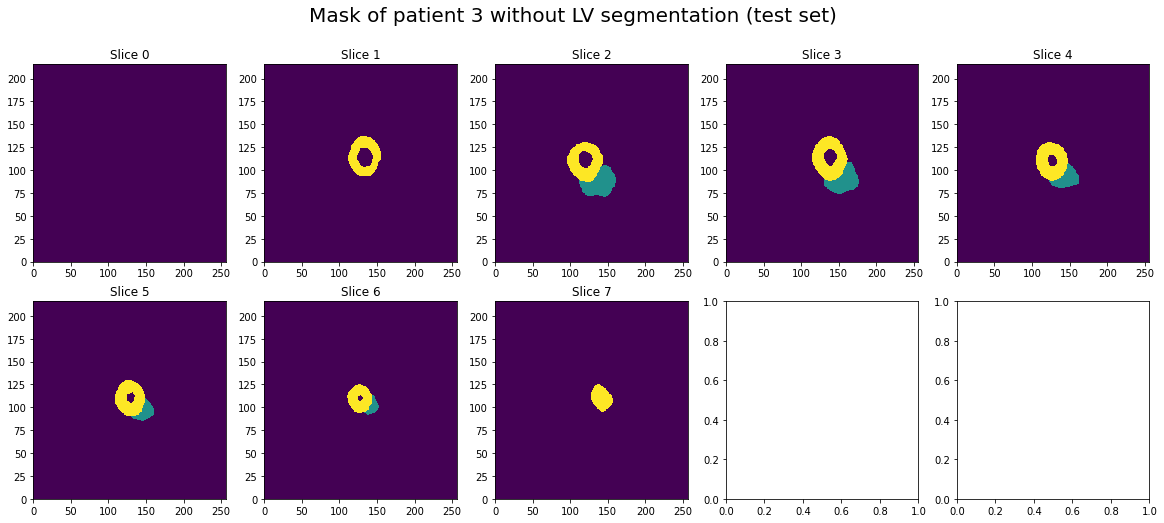

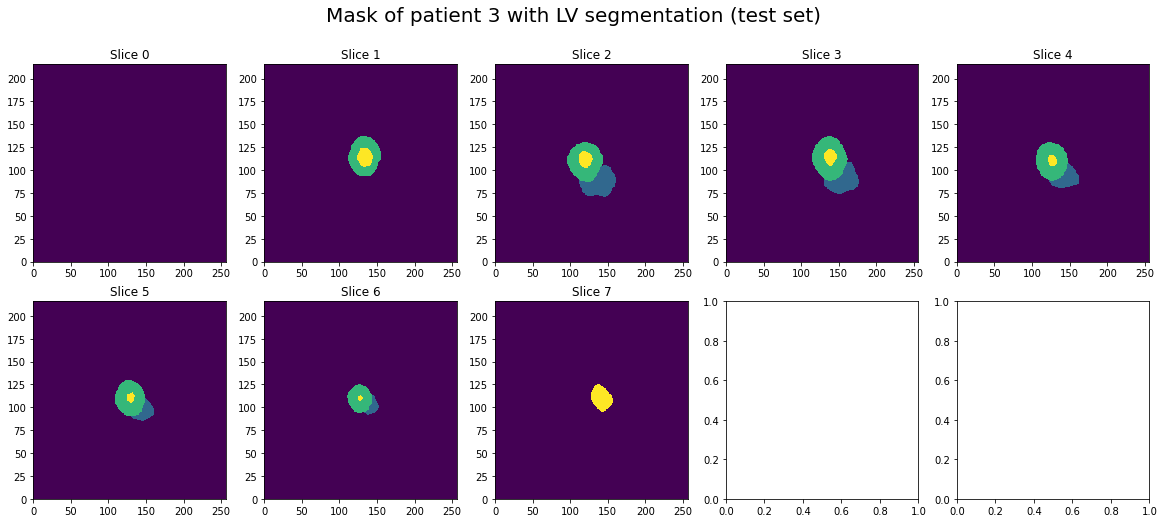

In [9]:
patient_idx=np.random.randint(mri_test.shape[0])
mask=mri_test[patient_idx][mask_idx]

new_mask=lv_seg(mask)

plot_slices(mask, title=f'Mask of patient {patient_idx} without LV segmentation (test set)')
plot_slices(new_mask, title=f'Mask of patient {patient_idx} with LV segmentation (test set)')

Now we apply this process test masks

In [10]:
mri_test_lv=mri_test.copy()

for i in range(mri_test.shape[0]):
    for j in range(1,4,2):
        mask=mri_test[i][j]
        mask_lv=lv_seg(mask)
        mri_test_lv[i][j]=mask_lv

---

We plot height and weight for each category 

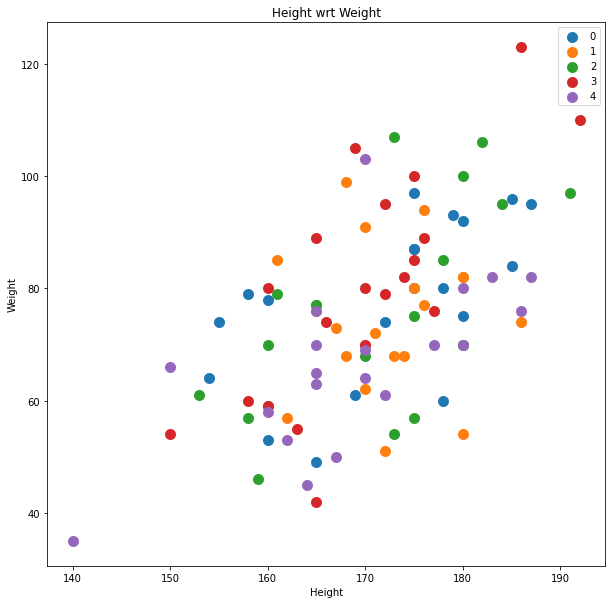

In [11]:
plt.figure(figsize=(10,10))
for i in range(len(X_cat)):
    plt.scatter(X_cat[i][:,0], X_cat[i][:,1], label=str(i), linewidths=5)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height wrt Weight')
plt.legend()
plt.show()

There seem to be no easy way to separate data into distinct categories only according to there distribution.<br>
It justifies the fact that we need to extract features from heart MRIs to seperate categories.

## Features extraction

Let's first compute the volume ratios between right and left ventricle at ED (paper [2]) :
$$\frac{V[RV]_{ED}}{V[LV]_{ED}}$$

In [12]:
def compute_volume(mask, index):
    """
    mask: (n_samples, width, height): ndarray
    index: integer
    """
    target_mask=(mask==index).astype(int) # extract the target segmentation
    areas=np.array([target_mask[i].sum() for i in range(target_mask.shape[0])])
    vol=areas.sum()
    return vol

def compute_lv_rv_ratio(lv_vol,rv_vol):
    return rv_vol/lv_vol

We use these functions on training and test sets

In [13]:
lvrv_ratio_train=np.zeros(n_train_samples)
lvrv_ratio_test=np.zeros(n_test_samples)

# Training set
for patient_idx in range(n_train_samples):
    mask=mri_train[patient_idx][MASK_IDX['ed']]
    rv_vol=compute_volume(mask,RV_IDX)
    lv_vol=compute_volume(mask,LV_IDX)
    ratio=compute_lv_rv_ratio(lv_vol, rv_vol)
    lvrv_ratio_train[patient_idx]=ratio


# Test set
for patient_idx in range(n_test_samples):
    mask=mri_test_lv[patient_idx][MASK_IDX['ed']]
    rv_vol=compute_volume(mask,RV_IDX)
    lv_vol=compute_volume(mask,LV_IDX)
    ratio=compute_lv_rv_ratio(lv_vol, rv_vol)
    lvrv_ratio_test[patient_idx]=ratio

In [14]:
X_train_lvrv=np.concatenate([X_train, lvrv_ratio_train.reshape(-1,1)], axis=1)
X_test_lvrv=np.concatenate([X_test, lvrv_ratio_test.reshape(-1,1)], axis=1)

print(f'Shape of X_train : {X_train_lvrv.shape}')
print(f'Shape of X_test : {X_test_lvrv.shape}')

Shape of X_train : (100, 3)
Shape of X_test : (50, 3)


Now let's compute the volume ratio between myocardium and left ventricle at ES and ED:
$$\frac{V[MYO]_{ES}}{V[LV]_{ES}}$$
$$\frac{V[MYO]_{ED}}{V[LV]_{ED}}$$

In [15]:
def compute_myo_lv_ratio(myo_vol,lv_vol):
    return myo_vol/lv_vol

In [16]:
myolv_ratio_train_ed=np.zeros(n_train_samples)
myolv_ratio_test_ed=np.zeros(n_test_samples)

myolv_ratio_train_es=np.zeros(n_train_samples)
myolv_ratio_test_es=np.zeros(n_test_samples)


# Training set
for patient_idx in range(n_train_samples):
    # compute ratio at es
    mask_es=mri_train[patient_idx][MASK_IDX['es']]
    myo_vol_es=compute_volume(mask_es,MYO_IDX)
    lv_vol_es=compute_volume(mask_es,LV_IDX)
    ratio_es=compute_myo_lv_ratio(myo_vol_es,lv_vol_es)
    myolv_ratio_train_es[patient_idx]=ratio_es
    # compute ration at ed
    mask_ed=mri_train[patient_idx][MASK_IDX['ed']]
    myo_vol_ed=compute_volume(mask_ed,MYO_IDX)
    lv_vol_ed=compute_volume(mask_ed,LV_IDX)
    ratio_ed=compute_myo_lv_ratio(myo_vol_ed,lv_vol_ed)
    myolv_ratio_train_ed[patient_idx]=ratio_ed


# Test set
for patient_idx in range(n_test_samples):
    # compute ratio at es
    mask_es=mri_test_lv[patient_idx][MASK_IDX['es']]
    rv_vol_es=compute_volume(mask_es,MYO_IDX)
    lv_vol_es=compute_volume(mask_es,LV_IDX)
    ratio_es=compute_myo_lv_ratio(myo_vol_es,lv_vol_es)
    myolv_ratio_test_es[patient_idx]=ratio_es
    # compute ratio at ed
    mask_es=mri_test_lv[patient_idx][MASK_IDX['ed']]
    rv_vol_ed=compute_volume(mask_ed,MYO_IDX)
    lv_vol_ed=compute_volume(mask_ed,LV_IDX)
    ratio_ed=compute_myo_lv_ratio(myo_vol_ed,lv_vol_ed)
    myolv_ratio_test_ed[patient_idx]=ratio_ed

In [17]:
X_train_myolv_es=np.concatenate([X_train_lvrv, myolv_ratio_train_es.reshape(-1,1)], axis=1)
X_test_myolv_es=np.concatenate([X_test_lvrv, myolv_ratio_test_es.reshape(-1,1)], axis=1)

X_train_myolv_ed=np.concatenate([X_train_myolv_es, myolv_ratio_train_ed.reshape(-1,1)], axis=1)
X_test_myolv_ed=np.concatenate([X_test_myolv_es, myolv_ratio_test_ed.reshape(-1,1)], axis=1)

print(f'Shape of X_train : {X_train_myolv_ed.shape}')
print(f'Shape of X_test : {X_test_myolv_ed.shape}')

Shape of X_train : (100, 5)
Shape of X_test : (50, 5)


We compute the left and right ventricular ejection fractions (LVEF and RVEF) for each patient :
$$LVEF=\frac{V[LV]_{ED}-V[LV]_{ES}}{V[LV]_{ED}}$$
$$RVEF=\frac{V[RV]_{ED}-V[RV]_{ES}}{V[RV]_{ED}}$$

In [18]:
# def compute_lvef(es_mask, ed_mask):
#     ed_vol=compute_volume(ed_mask, LV_IDX)
#     es_vol=compute_volume(es_mask, LV_IDX)
#     lvef=(ed_vol-es_vol)/ed_vol
#     return lvef
def compute_ef(es_mask, ed_mask, ventricle):
    if ventricle=='lv':
        ed_vol=compute_volume(ed_mask, LV_IDX)
        es_vol=compute_volume(es_mask, LV_IDX)
        ef=(ed_vol-es_vol)/ed_vol
    elif ventricle=='rv':
        ed_vol=compute_volume(ed_mask, RV_IDX)
        es_vol=compute_volume(es_mask, RV_IDX)
        ef=(ed_vol-es_vol)/ed_vol
    else:
        print('Invalid ventricle')
        return
    return ef

In [19]:
lvef_train=np.zeros(n_train_samples)
lvef_test=np.zeros(n_test_samples)

rvef_train=np.zeros(n_train_samples)
rvef_test=np.zeros(n_test_samples)

# Training set
for patient_idx in range(n_train_samples):
    es_mask=mri_train[patient_idx][MASK_IDX['es']]
    ed_mask=mri_train[patient_idx][MASK_IDX['ed']] 
    lvef=compute_ef(es_mask, ed_mask, 'lv')
    lvef_train[patient_idx]=lvef

    rvef=compute_ef(es_mask, ed_mask, 'rv')
    rvef_train[patient_idx]=rvef

# Test set
for patient_idx in range(n_test_samples):
    es_mask=mri_test_lv[patient_idx][MASK_IDX['es']]
    ed_mask=mri_test_lv[patient_idx][MASK_IDX['ed']] 
    lvef=compute_ef(es_mask, ed_mask, 'lv')
    lvef_test[patient_idx]=lvef

    rvef=compute_ef(es_mask, ed_mask, 'rv')
    rvef_test[patient_idx]=rvef

In [20]:
X_train_rvef=np.concatenate([X_train_myolv_ed, rvef_train.reshape(-1,1)], axis=1)
X_test_lvef=np.concatenate([X_test_myolv_ed, rvef_test.reshape(-1,1)], axis=1)



X_train_lvef=np.concatenate([X_train_rvef, lvef_train.reshape(-1,1)], axis=1)
X_test_lvef=np.concatenate([X_test_lvef, lvef_test.reshape(-1,1)], axis=1)

print(f'Shape of X_train : {X_train_lvef.shape}')
print(f'Shape of X_test : {X_test_lvef.shape}')

Shape of X_train : (100, 7)
Shape of X_test : (50, 7)


## Classification

Because we don't have many training samples, we can't use deep learning for classification. Instead we will try and compare the following methods :
- Random Forest
- Naive Bayesian 
- Multiclass SVM
- KNN

Moreover we need to avoid over-fitting. The two first methods are known not to overfit.

### Random Forest

We start with this classifier because it is well suited for a low amoiunt of data and we don't risk overfitting, as random forest is made of weak classifiers.<br/>
We use cross-validation to find the most relevant amount of decision trees in the forest and their maximum depth.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print('Fitting random forest')
rfc_params={'n_estimators': list(range(40,200,20)), 'max_depth': list(range(1,50,10))}
clf_rfc_cv=GridSearchCV(RandomForestClassifier(), rfc_params)
clf_rfc_cv.fit(X_train_lvef, y_train)

print(f'Best hyperparameters : {clf_rfc_cv.best_params_}')
print(f'Best score for these parameters : {clf_rfc_cv.best_score_}')

Fitting random forest
Best hyperparameters : {'max_depth': 31, 'n_estimators': 60}
Best score for these parameters : 0.9199999999999999


We know save use this model to predict `y_test`

In [35]:
y_test_rfc=clf_rfc_cv.predict(X_test_lvef)
save_to_csv(y_test_rfc)

Results successfully saved to ./SampleSubmission.csv


### Naive Bayes Classification

As well as random forests, naive Bayes classification is well suited for training sets with a small amount of samples.<br/>
However it is normal to get worse results as random forest 

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

print('Fitting Multinomial Naive Bayes')
nb_params={'alpha': list(np.linspace(1,5,10))} # smoothing parameter
clf_nb_cv=GridSearchCV(MultinomialNB(), nb_params)
clf_nb_cv.fit(X_train_lvef, y_train)

print(f'Best hyperparameters : {clf_nb_cv.best_params_}')
print(f'Best score for these parameters : {clf_nb_cv.best_score_}')

Fitting Multinomial Naive Bayes
Best hyperparameters : {'alpha': 2.7777777777777777}
Best score for these parameters : 0.6000000000000001


In [24]:
y_test_nb=clf_nb_cv.predict(X_test_lvef)
save_to_csv(y_test_nb)

Results successfully saved to ./SampleSubmission.csv


In [25]:
print('Fitting Gaussian Naive Bayes')
clf_gauss=GaussianNB()
clf_gauss.fit(X_train_lvef,y_train)
print(f'Score for training set : {clf_gauss.score(X_train_lvef,y_train)}')

Fitting Gaussian Naive Bayes
Score for training set : 0.92


In [26]:
y_test_gauss=clf_gauss.predict(X_test_lvef)
save_to_csv(y_test_gauss)

Results successfully saved to ./SampleSubmission.csv


### QDA

In [34]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf_qda=QuadraticDiscriminantAnalysis()
# clf_qda=QuadraticDiscriminantAnalysis(reg_param=0.3)
clf_qda.fit(X_train_lvef, y_train)

y_test_qda=clf_qda.predict(X_test_lvef)

print(f'Training score : {clf_qda.score(X_train_lvef, y_train)}')

Training score : 0.95


In [28]:
# y_test=rfc_cv.predict(X_test_lvef)
submit_csv2=pd.read_csv('SampleSubmission.csv')
submit_csv2['Category']=y_test_qda
submit_csv2.to_csv('SampleSubmission.csv', index=False)

### KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn_params={'n_neighbors': list(range(1,5))}

clf_knn_cv=GridSearchCV(KNeighborsClassifier(), clf_knn_params) 
clf_knn_cv.fit(X_train_lvef, y_train)

# clf_knn=KNeighborsClassifier(n_neighbors=4)
# clf_knn.fit(X_train_lvef, y_train)

# y_test_knn=clf_knn.predict(X_test_lvef)
# print(f'Training score {clf_knn.score(X_train_lvef, y_train)}')

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4]})

In [30]:
clf_knn_cv.best_score_

0.29

### SVM

In [31]:
from sklearn.svm import SVC

svm_params={'degree': list(range(3,5)), 'kernel': ['rbf','poly']}

clf_svm_cv=GridSearchCV(SVC(), svm_params)
clf_svm_cv.fit(X_train_lvef, y_train)
clf_svm_cv.best_score_

0.25

In [32]:
clf_svm_cv.best_score_

0.25

Write predictions into csv file.